# Sea ice plotting examples

This script shows how to load and plot sea ice concentration from sea ice models (CICE5, and SIS2) output, while also indicating how to get around some of the pitfalls and foibles in CICE temporal and spatial gridding.

Requirements: The `conda/analysis3` module from `/g/data/xp65/public/modules`. 

Firstly, load modules:

In [1]:
import intake
from dask.distributed import Client
from datetime import timedelta
import cf_xarray as cfxr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib.path as mpath
import cmocean.cm as cmo

In [2]:
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 14
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33869,Workers: 14
Dashboard: /proxy/8787/status,Total threads: 14
Started: Just now,Total memory: 63.00 GiB
Comm: tcp://127.0.0.1:33627,Total threads: 1
Dashboard: /proxy/34341/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:40629,


In [3]:
client.dashboard_link

'/proxy/8787/status'

Choose a model to use. Note that the `sis2` model is smaller than the `cice5` model, so may be easier to use if you have limited computing power.

In [4]:
#Choose which model we are working with
# MODEL='cice5'
MODEL='sis2'

Open the catalog

In [5]:
catalog = intake.cat.access_nri

The dictionary below specifies experiment, start and ending times for each model we can use (CICE5 with MOM5 or SIS2 with MOM6). This example will work with RYF forcing experiments and sea ice concentration variable, which is called `aice_m` in mom5 and `siconc` in mom6.

If you want a different experiment, or a different time period, change the necessary values. Note that we are just loading the last 10 years here.

Note also the `decode_coords=False` flag. **This gets around some messy issues with the way xarray decides to load CICE grids**:

In [6]:
sic_args = {
    "cice5": { #cice5 is part of ACCESS-OM2
        "expt": "01deg_jra55v13_ryf9091",
        "variable": "aice_m",
        "decode_coords": False
    },
    "sis2": { #sis2 is used for testing MOM6
        "expt": "OM4_025.JRA_RYF",
        "variable": "siconc",
        "decode_coords": True
    },
    #In the future, we will add a CICE6 option (i.e. the future ACCESS-OM3)
}

area_variable = {
    "cice5": "area_t" ,
    "sis2": "areacello"
}

geo_variables = {
    "cice5":['geolon_t', 'geolat_t'] ,
    "sis2": ['geolon', 'geolat']
}

In [7]:
cat_subset = catalog[sic_args[MODEL]['expt']]
cat_subset

,unique
filename,1140
file_id,12
path,1140
filename_timestamp,95
frequency,4
start_date,95
end_date,96
variable,119
variable_long_name,109
variable_standard_name,50


In [8]:
var_search = cat_subset.search(variable=sic_args[MODEL]['variable'], frequency="1mon")
var_search

,unique
filename,95
file_id,1
path,95
filename_timestamp,95
frequency,1
start_date,95
end_date,95
variable,12
variable_long_name,12
variable_standard_name,1


In [9]:
darray = var_search.to_dask( 
    xarray_open_kwargs=dict(
        decode_coords = sic_args[MODEL]['decode_coords']
    ) , 
    xarray_combine_by_coords_kwargs=dict(
        compat="override",
        data_vars="minimal",
        coords="minimal"
    )
)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.02/lib/python3.11/site-packages/intake_esm/source.py:82: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.02/lib/python3.11/site-packages/intake_esm/source.py:82: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.02/lib/python3.11/site-packages/intake_esm/source.py:82: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTi

In [10]:
darray = darray[sic_args[MODEL]['variable']]
sic = darray
sic

<xarray.DataArray 'siconc' (time: 1140, yT: 1080, xT: 1440)> Size: 7GB
dask.array<concatenate, shape=(1140, 1080, 1440), dtype=float32, chunksize=(1, 540, 720), chunktype=numpy.ndarray>
Coordinates:
  * xT       (xT) float64 12kB -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * yT       (yT) float64 9kB -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
  * time     (time) object 9kB 1900-01-16 12:00:00 ... 1994-12-16 12:00:00
Attributes:
    units:          0-1
    long_name:      ice concentration
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT

**Another messy thing about CICE is that it thinks that monthly data for, say, January occurs at midnight on Jan 31 -- while xarray interprets this as the first milllisecond of February.**  
  
To get around this, note that we loaded data from February above, and we now subtract 12 hours from the time dimension. This means that, at least data is sitting in the correct month, and really helps to compute monthly climatologies correctly.

In [11]:
if MODEL =='cice5' :
    sic['time'] = sic.time.to_pandas() - timedelta(hours = 12)

In [12]:
sic = sic.sel(time=slice('1981','1990'))
sic

<xarray.DataArray 'siconc' (time: 120, yT: 1080, xT: 1440)> Size: 746MB
dask.array<getitem, shape=(120, 1080, 1440), dtype=float32, chunksize=(1, 540, 720), chunktype=numpy.ndarray>
Coordinates:
  * xT       (xT) float64 12kB -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * yT       (yT) float64 9kB -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
  * time     (time) object 960B 1981-01-16 12:00:00 ... 1990-12-16 12:00:00
Attributes:
    units:          0-1
    long_name:      ice concentration
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT

In [13]:
if MODEL == "cice5":
    time_chunk = 3
    coords = ["nj", "ni"]
elif MODEL == "sis2":
    time_chunk = 10
    coords = ["yT", "xT"]

chunk_dict = {k: -1 for k in coords}
chunk_dict["time"] = time_chunk

sic = sic.chunk(chunk_dict)
sic

<xarray.DataArray 'siconc' (time: 120, yT: 1080, xT: 1440)> Size: 746MB
dask.array<rechunk-merge, shape=(120, 1080, 1440), dtype=float32, chunksize=(10, 1080, 1440), chunktype=numpy.ndarray>
Coordinates:
  * xT       (xT) float64 12kB -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * yT       (yT) float64 9kB -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
  * time     (time) object 960B 1981-01-16 12:00:00 ... 1990-12-16 12:00:00
Attributes:
    units:          0-1
    long_name:      ice concentration
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT

Note that `aice_m` is the monthly average of fractional ice area in each grid cell aka the concentration. **To find the actual area of the ice we need to know the area of each cell. Unfortunately, CICE doesn't save this for us ... but the ocean model does.** So, let's load `area_t` from the ocean model, and rename the coordinates in our ice variable to match the ocean model. Then we can multiply the ice concentration with the cell area to get a total ice area.

In [14]:
var_search = cat_subset.search(variable=[area_variable[MODEL]])
var_search = var_search.search(path=var_search.df['path'][0])
var_search
darray = var_search.to_dask()
darray = darray.assign_coords(geolat=(("yh", "xh"), darray["geolat"].data), geolon=(("yh", "xh"), darray["geolon"].data))
# darray
darray = darray[[area_variable[MODEL], ]]# + geo_variables[MODEL]]
# darray
area = darray.load()
area

<xarray.Dataset> Size: 19MB
Dimensions:    (yh: 1080, xh: 1440)
Coordinates:
  * xh         (xh) float64 12kB -299.7 -299.5 -299.2 ... 59.53 59.78 60.03
  * yh         (yh) float64 9kB -80.39 -80.31 -80.23 ... 89.73 89.84 89.95
    geolon     (yh, xh) float32 6MB nan nan nan nan nan ... 60.0 60.0 60.0 60.0
    geolat     (yh, xh) float32 6MB nan nan nan nan ... 64.44 64.33 64.22 64.11
Data variables:
    areacello  (yh, xh) float32 6MB nan nan nan ... 3.27e+06 2.097e+06 9.053e+05
Attributes: (12/20)
    NumFilesInSet:                            1
    title:                                    #
    grid_type:                                regular
    grid_tile:                                N/A
    intake_esm_vars:                          ['xh', 'yh', 'time', 'xq', 'yq'...
    intake_esm_attrs:filename:                19000101.ocean_static.nc
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,cell_area,sea_floor_depth_...
    intake_esm_attrs:variable_cell_methods:   ,,,,,area:sum yh:sum xh:sum tim...
    intake_esm_attrs:variable_units:          degrees_east,degrees_north,days...
    intake_esm_attrs:realm:                   ocean
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   XXXXXXXX_ocean_static.fx

cfr = darray.cf
cfr

Our CICE data is missing x&y coordinate values, so we can also get them from area_t

So that our new coordinates are recognised as cf standard, we also need to copy the attributes. This notebook is designed to use `cf-xarray`. This means the rest of the notebook is [Model Agnostic](https://cosima-recipes.readthedocs.io/en/latest/Tutorials/Model_Agnostic_Analysis.html).

We now need to match the incoming area data to the sea ice data through coordinate names:

In [15]:
if MODEL =='cice5' :
    # Bring the latitude, longitude values into the main data (replace the indices)
    sic.coords['ni'] = area['xt_ocean'].values
    sic.coords['nj'] = area['yt_ocean'].values

    sic.ni.attrs = area.xt_ocean.attrs
    sic.nj.attrs = area.yt_ocean.attrs
    
    sic = sic.rename(({'ni': 'xt_ocean', 'nj': 'yt_ocean'}))

elif MODEL == "sis2":

    # The SIS2 main data already has the real latitude, longitude values - just need to rename
    # them so they match the names in the area data
    sic = sic.rename(({"xT": "xh", "yT": "yh"}))

In [16]:
sic.cf

Coordinates:
             CF Axes: * X: ['xh']
                      * Y: ['yh']
                      * T: ['time']
                        Z: n/a

      CF Coordinates: * longitude: ['xh']
                      * latitude: ['yh']
                      * time: ['time']
                        vertical: n/a

       Cell Measures:   area, volume: n/a

      Standard Names:   n/a

              Bounds:   n/a

       Grid Mappings:   n/a

Now that we have axes with cf compliant coordinates, we can select using `latitude` keywords.

# Sea Ice Area

Let's look at a timeseries of SH sea ice area. Area is defined (per convention) as the sum of sea ice concentration multiply by the area of each grid cell (and masked for sea ice concentration above 15%)

By convention, sea-ice area for a region or basin is the sum of the area's where concentration is greater than 15%. 
We also need to drop geolon and geolat so we have unique longitude and latitude to reference

In [17]:
sic = sic.where(sic >= 0.15)

si_area = sic * area

if MODEL=='cice5':
    si_area = si_area.drop_vars({'geolon_t', 'geolat_t'})

si_area.cf

Coordinates:
             CF Axes: * X: ['xh']
                      * Y: ['yh']
                      * T: ['time']
                        Z: n/a

      CF Coordinates: * longitude: ['xh']
                      * latitude: ['yh']
                      * time: ['time']
                        vertical: n/a

       Cell Measures:   area, volume: n/a

      Standard Names:   n/a

              Bounds:   n/a

       Grid Mappings:   n/a

Data Variables:
       Cell Measures:   area, volume: n/a

      Standard Names:   n/a

              Bounds:   n/a

       Grid Mappings:   n/a

In [18]:
SH_area = si_area.cf.sel(latitude=slice(-90, -45)).cf.sum(['latitude', 'longitude'])
NH_area = si_area.cf.sel(latitude=slice(45, 90)).cf.sum(['latitude', 'longitude'])

SH_area

<xarray.Dataset> Size: 1kB
Dimensions:    (time: 120)
Coordinates:
  * time       (time) object 960B 1981-01-16 12:00:00 ... 1990-12-16 12:00:00
Data variables:
    areacello  (time) float32 480B dask.array<chunksize=(10,), meta=np.ndarray>

As we are using a repeat year forcing experiemnt, the sea ice cycle is very regular:

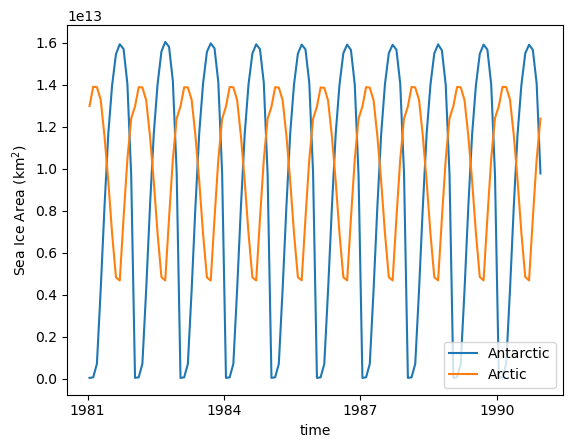

In [19]:
SH_area["areacello"].plot(label = 'Antarctic')
NH_area["areacello"].plot(label = 'Arctic')

plt.legend(loc='lower right')
plt.ylabel('Sea Ice Area (km$^{2}$)');

And the seasonal cycle of sea-ice area:

Text(0, 0.5, 'Sea Ice Area (km$^{2}$)')

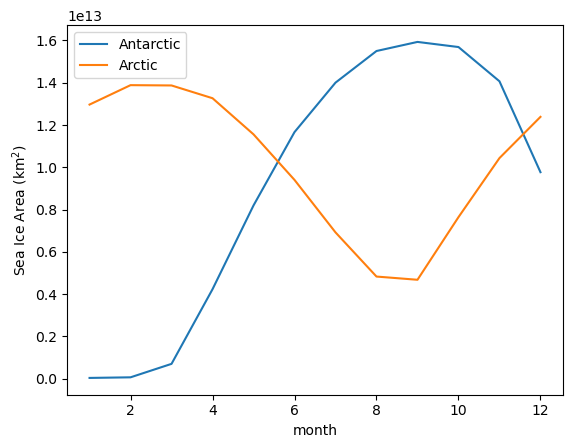

In [20]:
SH_area["areacello"].groupby('time.month').mean('time').plot(label='Antarctic')
NH_area["areacello"].groupby('time.month').mean('time').plot(label='Arctic')

plt.legend()
plt.ylabel('Sea Ice Area (km$^{2}$)')

# Making Maps

If we just plot a selected month now, you see that everything North of 65N is skewed. 

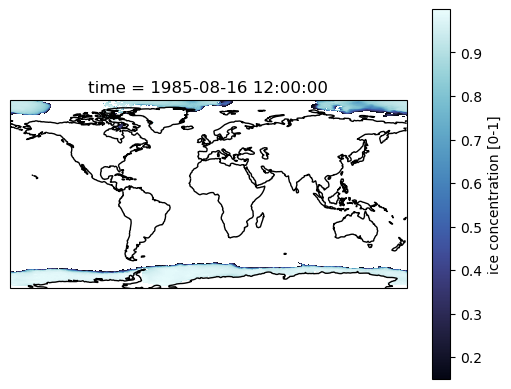

In [21]:
ax = plt.subplot(projection = ccrs.PlateCarree())

sic.sel(time='1985-08').plot(cmap = cmo.ice)
ax.coastlines()

Most of our work is in the Southern Ocean, so maybe we don't care. But if you are interested in the Arctic, then we need to account for the tri-polar ocean grid that out models use. The easiest way out of that is using contourf, and the passing the x and y coordinates.

See [Making Maps with Cartopy](https://cosima-recipes.readthedocs.io/en/latest/Tutorials/Making_Maps_with_Cartopy.html) tutorial for more help with plotting!

We need the geolon and geolat fields from the model for the actual (two-pole) coordinates, instead of the model (three-pole) coordinates.

In [22]:
area

<xarray.Dataset> Size: 19MB
Dimensions:    (yh: 1080, xh: 1440)
Coordinates:
  * xh         (xh) float64 12kB -299.7 -299.5 -299.2 ... 59.53 59.78 60.03
  * yh         (yh) float64 9kB -80.39 -80.31 -80.23 ... 89.73 89.84 89.95
    geolon     (yh, xh) float32 6MB nan nan nan nan nan ... 60.0 60.0 60.0 60.0
    geolat     (yh, xh) float32 6MB nan nan nan nan ... 64.44 64.33 64.22 64.11
Data variables:
    areacello  (yh, xh) float32 6MB nan nan nan ... 3.27e+06 2.097e+06 9.053e+05
Attributes: (12/20)
    NumFilesInSet:                            1
    title:                                    #
    grid_type:                                regular
    grid_tile:                                N/A
    intake_esm_vars:                          ['xh', 'yh', 'time', 'xq', 'yq'...
    intake_esm_attrs:filename:                19000101.ocean_static.nc
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,cell_area,sea_floor_depth_...
    intake_esm_attrs:variable_cell_methods:   ,,,,,area:sum yh:sum xh:sum tim...
    intake_esm_attrs:variable_units:          degrees_east,degrees_north,days...
    intake_esm_attrs:realm:                   ocean
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   XXXXXXXX_ocean_static.fx

In [23]:
sic=sic.assign_coords({
    'geolat': area.geolat,
    'geolon': area.geolon
})

Use contourf, and the geolon and geolat fields

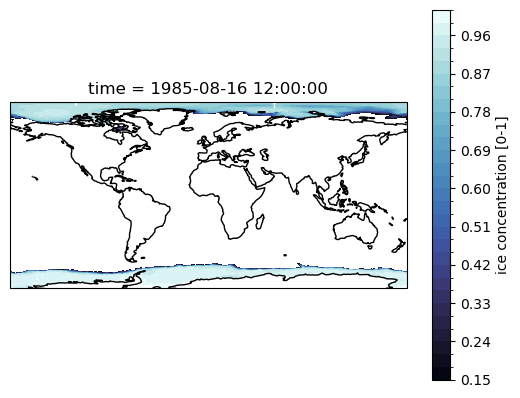

In [24]:
ax = plt.subplot(projection=ccrs.PlateCarree())

sic.sel(time='1985-08').squeeze('time').plot.contourf(
    transform = ccrs.PlateCarree(),
    x = 'geolon',
    y = 'geolat',
    levels = 33,
    cmap = cmo.ice
)

ax.coastlines()

Using cartopy, we can make Polar Stereographic plots of sea ice concentration for a selected month, as follows:

In [25]:
def plot_si_conc(data):
    """ A function for plotting tri-polar data"""
    ax = plt.gca()

    # Map the plot boundaries to a circle
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)

    # Add land features and gridlines
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black',
                   facecolor = 'gainsboro'), zorder = 2)

    data.plot.contourf(
        transform = ccrs.PlateCarree(),
        x = 'geolon', 
        y = 'geolat', 
        levels = np.arange(0.15, 1.05, 0.05),
        cmap = cmo.ice,
        cbar_kwargs = {
            'label':'Sea Ice Concentration'
        }
    )

    gl = ax.gridlines(
            draw_labels=True, linewidth=1, color='gray', alpha=0.2, linestyle='--',
            ylocs = np.arange(-80, 81, 10)
        )

    ax.coastlines()

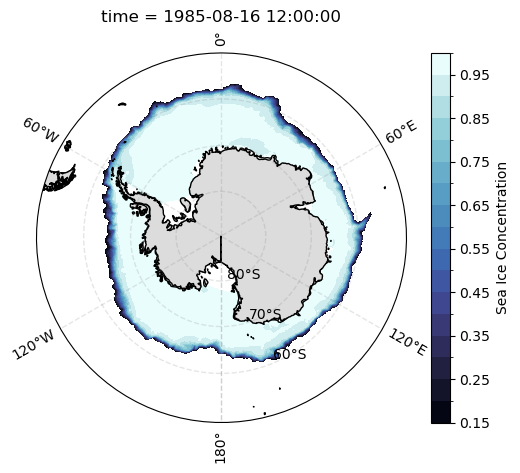

In [26]:
def plot_sh_si_conc():
    ax = plt.subplot(projection=ccrs.SouthPolarStereo())

    ax.set_extent([-180, 180, -90, -50], crs=ccrs.PlateCarree())

    plot_si_conc(
        sic.cf.sel(time='1985-08').squeeze('time')
    )

plot_sh_si_conc()

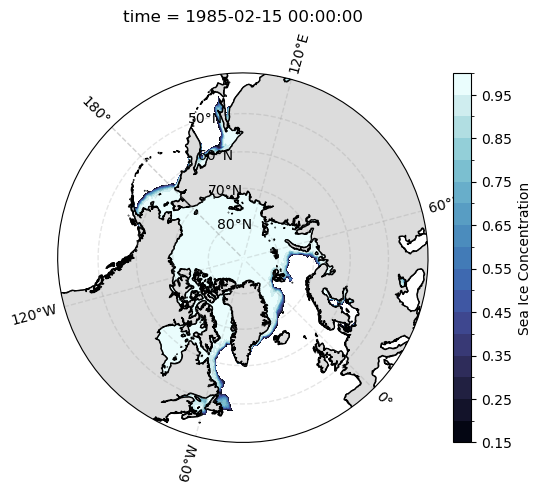

In [27]:
def plot_nh_si_conc():
    ax = plt.subplot(projection=ccrs.NorthPolarStereo(central_longitude=-45))
    
    ax.set_extent([-180, 180, 40, 90], crs=ccrs.PlateCarree())

    plot_si_conc(
        sic.cf.sel(time='1985-02').squeeze('time')
    )

plot_nh_si_conc()

Once we are happy with your plot, we can save the plot to disk using `plt.savefig('filepath/filename')` function at the end of the cell containing the plot we want to save, as shown below. Note that your filename must contain the file (e.g., pdf, jpeg, png, etc.).  
For more information on the options available to save figures refer to [Matplotlib documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.savefig.html).

```python
plot_sh_si_conc()
plt.savefig('MyFirstSeaIcePlot.png', dpi = 300)
```

In [28]:
client.close()